# (1) Importing all necessary Libraries;

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import os
import keras
import cv2
import seaborn as sns
import tensorflow as tf
import matplotlib.image as mpimg
import torch
import torchvision
import torchvision.models as models

In [2]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Flatten,Dense,Conv2D,MaxPooling2D,BatchNormalization,Dropout
from keras.callbacks import TensorBoard
from keras.models import load_model
from skimage.transform import rescale, resize
from sklearn.metrics import confusion_matrix 
from torchvision import transforms, datasets
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

### Warning............

In [3]:
from warnings import filterwarnings

filterwarnings('ignore')
print("Warnings ignored!!")

Warnings ignored!!


# (2) Loading Dataset;

In [4]:
data_dir = 'data'

In [5]:
test_data = 'data/test'
train_data = 'data/train'

In [6]:
def get_subfolders_and_image_counts(directory): 
    subfolders = {}
    for subdir, dirs, files in os.walk(directory): 
        if dirs:
            for folder in dirs:
                folder_path = os.path.join(subdir, folder)
                num_images = len([file for file in os.listdir(folder_path)
                                  if file.endswith(('.png', '.jpg', '.jpeg'))])
                subfolders[folder] = num_images
            return subfolders

In [7]:
train_subfolders   =   get_subfolders_and_image_counts(train_data)
test_subfolders   =    get_subfolders_and_image_counts(test_data)

In [8]:
print("Training Subfolders and Image Counts ----->")
for folder, count in train_subfolders.items():
    print(f"{folder}:  {count}  images")

Training Subfolders and Image Counts ----->
cats:  10000  images
dogs:  10000  images


In [9]:
print("\nTest Subfolders and Image Counts ------->")
for folder, count in test_subfolders.items():
    print(f"{folder}:  {count}  images")


Test Subfolders and Image Counts ------->
cats:  2500  images
dogs:  2500  images


# (3) Data Preprocessing;

### Normalization:-
The images are stored in numpy array format (0-255), to which we need to normalize btw (0-1)

In [10]:
# Training Data

train_ds = keras.utils.image_dataset_from_directory(
    directory = 'data/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

test_ds = keras.utils.image_dataset_from_directory(
    directory = 'data/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)


# Validation Data
validation_ds = keras.utils.image_dataset_from_directory(
    directory = 'data/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [11]:
train_datagen = ImageDataGenerator( rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255) 

In [12]:
train_generator  =  train_datagen.flow_from_directory(train_data,
                                    target_size=(224, 224), 
                                    batch_size=32, 
                                    class_mode='categorical',
                                    subset='training')
validation_generator = train_datagen.flow_from_directory( train_data,
                        target_size=(224, 224), 
                        batch_size=32, 
                        class_mode='categorical', 
                        subset='validation'
)
test_generator = test_datagen.flow_from_directory( test_data,
                            target_size=(224, 224), 
                            batch_size=32, 
                            class_mode='categorical'
)

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [13]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

# (4) Model Architecture;

In [14]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))


model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

#####  Fitting data...........

In [19]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 937s 1s/step - accuracy: 0.5653 - loss: 2.1514 - val_accuracy: 0.6999 - val_loss: 0.5792
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1414s 2s/step - accuracy: 0.7086 - loss: 0.5702 - val_accuracy: 0.7188 - val_loss: 0.5647
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 28392s 45s/step - accuracy: 0.7573 - loss: 0.4982 - val_accuracy: 0.7903 - val_loss: 0.4572
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 909s 1s/step - accuracy: 0.8031 - loss: 0.4243 - val_accuracy: 0.8449 - val_loss: 0.3477
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 906s 1s/step - accuracy: 0.8381 - loss: 0.3729 - val_accuracy: 0.8509 - val_loss: 0.3405
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 908s 1s/step - accuracy: 0.8608 - loss: 0.3168 - val_accuracy: 0.8864 - val_loss: 0.2596
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 912s 1s/step - accuracy: 0.9039 - loss: 0.2366 - val_accuracy: 0.9304 - val_loss: 0.1753
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 861s 1s/step - accuracy: 0.9364 - loss: 0.1594 - val_

In [21]:
test_loss, test_acc = model.evaluate(validation_ds) 

625/625 ━━━━━━━━━━━━━━━━━━━━ 121s 193ms/step - accuracy: 0.9615 - loss: 0.1103


In [22]:
print(f"\nTest Accuracy => {test_acc}")


Test Accuracy => 0.9625999927520752


# (5) Visualization;

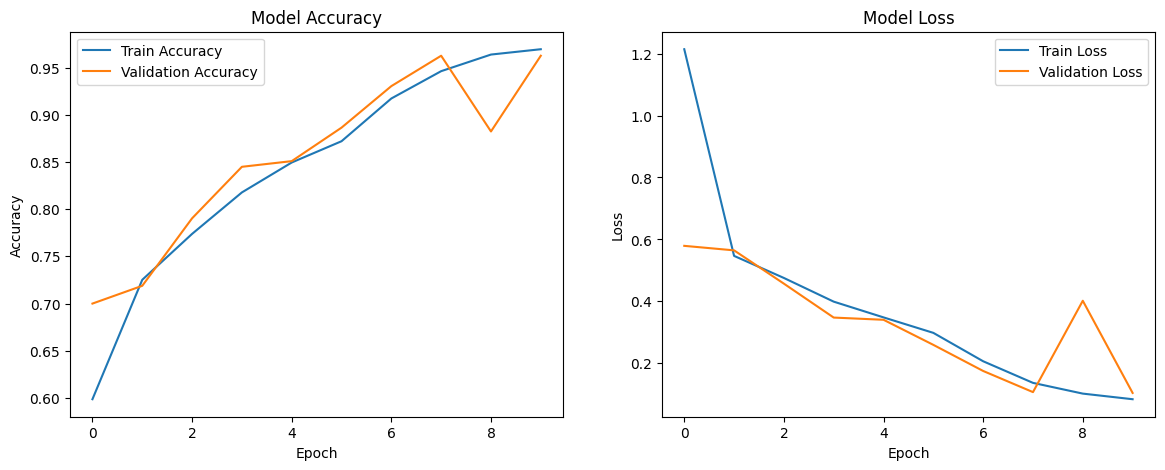

In [23]:
def  plot_training_history(history):
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy') 
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy') 
        plt.xlabel('Epoch') 
        plt.ylabel('Accuracy') 
        plt.legend()
        plt.subplot(1, 2, 2) 
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss') 
        plt.title('Model Loss')
        plt.xlabel('Epoch') 
        plt.ylabel('Loss') 
        plt.legend()
        plt.show()
plot_training_history(history)